E

# Importing the libraries

In [4]:
# reading in data
import re
import string
import numpy as np 
import random
import pandas as pd 

#Vissualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go # pip install plotly==4.8.1
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #pip install wordcloud

#Preprocessing
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
nltk.download('averaged_perceptron_tagger')
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

#modeling
from sklearn.feature_extraction.text import CountVectorizer

#csv paths
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elton\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Below is a helper Function which generates random colors which will be used to give different colors to our plots.

In [5]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Getting Data

In [6]:
# Load dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
ss_df = pd.read_csv('sample_submission.csv')

In [7]:
train_df.head()

sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

In [8]:
print('___basic info of the train data___')
print(train_df.info())
print('Dataset size:', train_df.shape)
print('Columns are:',train_df.columns)

print('___Print the head/Tain of the train data_____')
print(train_df.head())
print('________________________')
print(train_df.tail())

___basic info of the train data___
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB
None
Dataset size: (15819, 3)
Columns are: Index(['sentiment', 'message', 'tweetid'], dtype='object')
___Print the head/Tain of the train data_____
   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954
________________________

As seen above, when we print some basic information about the data. We can notice right away how each row is represented either by int64 or Object (for TextData). Finally after plotting the histogram of the sentiment data, its clear that there more positive examples then negative examples. (1 being denoted as positive sentiment while 0 being denoted as negative.). There are four sentiments in total.

# Data cleaning and Preprocessing

we added a long list of contraction to expand most of the contracted form to its original form such as “don’t” to “do not”. Regex is used to parse the documents, and filtered numbers, URL, punctuation, etc. 

Below are the steps  taken to clean the tweets.
1. Contraction check: check if there’s any contracted form, and replace it with its original form
2. Filtering punctuation, white space, numbers, URL using regex methods while removing the text content of hashtag and Removed @mention
2. Lemmatize: lemmatized each token using Spacy method ‘.lemma_’. Pronouns are kept as they are since Spacy lemmatizer transforms every pronoun to “-PRON-”
3. Special character removal
4. stop words removal keeping the word not,
more to be added

## Removing the noise

Replacing contaction phrases 

In [9]:
contractions_dict = contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


def expand_contractions(text):
    for word in text.split():
        if word.lower() in contractions_dict:
            text = text.replace(word,contractions_dict[word.lower()])
    return text

train_df['fixed_cntractions'] = train_df['message'].apply(lambda x: expand_contractions(x))
test_df['fixed_cntractions'] = test_df['message'].apply(lambda x: expand_contractions(x))

### Dealig with the punctuations and the links present in the messages

In [10]:
def remov_pnct(text):
    '''The Function makes text lowercase,removes links, punctuation(!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~)
    and words containing numbers.'''
    
    text = str(text).lower() #Make text lowercase
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())# remove @user, #word and link
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) ##remove punctuation
    text = re.sub('\n', '', text)
    text = ''.join([i for i in text[:] if not i.isdigit()]) #remove numbers
    return text

train_df['clean_message'] = train_df['fixed_cntractions'].apply(lambda x: remov_pnct(x))
test_df['clean_message'] = test_df['fixed_cntractions'].apply(lambda x: remov_pnct(x))

In [11]:
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: it has / it is 2016, and ...   

                                       clean_message  
0  polyscimajor epa chief does not think carbon d...  
1  it has it is not like we lack evidence of anth...  
2  rt researchers say we have three years to act ...  
3  wired  was a pivotal year in the war on climat...  
4  rt it has it is  and a racist sexist climate c...

### Parts of Speech Tagging (POS)

In [12]:
nltk.download('punkt')
train_df['message_POS'] = train_df['clean_message'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
test_df['message_POS'] = test_df['clean_message'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
train_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: it has / it is 2016, and ...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   
1  it has it is not like we lack evidence of anth...   
2  rt researchers say we have three years to act ...   
3  wired  was a pivotal year in the war on climat...   
4  rt it has it is  and a racist sexist climate c...   

                                         message_POS  
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...  
1  [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...  
2  [(rt, NN), (researchers, NNS), (say, VBP), (we...  
3  [(wired, VBN), (was, VBD), (a, DT), (pivotal, ...  
4  [(rt, NN), (it, PRP), (has, VBZ), (it, PRP), (...

### Lemmatisation


In [13]:
nlp = spacy.load("en_core_web_lg")
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [14]:
train_df["lemmaa"] =train_df.apply(lambda x: lemmatizer(x['clean_message']), axis=1)
test_df["lemmaa"] =test_df.apply(lambda x: lemmatizer(x['clean_message']), axis=1)

In [15]:
train_df.head() 

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: it has / it is 2016, and ...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   
1  it has it is not like we lack evidence of anth...   
2  rt researchers say we have three years to act ...   
3  wired  was a pivotal year in the war on climat...   
4  rt it has it is  and a racist sexist climate c...   

                                         message_POS  \
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   
1  [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...   
2  [(rt, NN), (researchers, NNS), (say, VBP), (we...   
3  [(wired, VBN), (was, VBD), (a, DT), (pivotal, ...   
4  [(rt, NN), (it, PRP), (has, VBZ), (it, PRP), (...   

                                              lemmaa  
0  polyscimajor epa chief do not think carbon dio...  
1  -PRON- have -PRON- be not like -PRON- lack evi...  
2  rt researcher say -PRON- have three year to ac...  
3  wired   be a pivotal year in the war on climat...  
4  rt -PRON- have -PRON- be   and a racist sexist...

Removing the _PRON_ and rt   form column lemmaa 

In [16]:
def remove(text):
    '''removing the words -PRON- and rt'''
    text = re.sub(r'-PRON-','',text)
    text = re.sub(r'rt' , '' , text) 
    return text

In [17]:
train_df['clean_lemma'] = train_df['lemmaa'].apply(lambda x: remove(x))
test_df['clean_lemma'] = test_df['lemmaa'].apply(lambda x: remove(x))
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: it has / it is 2016, and ...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   
1  it has it is not like we lack evidence of anth...   
2  rt researchers say we have three years to act ...   
3  wired  was a pivotal year in the war on climat...   
4  rt it has it is  and a racist sexist climate c...   

                                         message_POS  \
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   
1  [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...   
2  [(rt, NN), (researchers, NNS), (say, VBP), (we...   
3  [(wired, VBN), (was, VBD), (a, DT), (pivotal, ...   
4  [(rt, NN), (it, PRP), (has, VBZ), (it, PRP), (...   

                                              lemmaa  \
0  polyscimajor epa chief do not think carbon dio...   
1  -PRON- have -PRON- be not like -PRON- lack evi...   
2  rt researcher say -PRON- have three year to ac...   
3  wired   be a pivotal year in the war on climat...   
4  rt -PRON- have -PRON- be   and a racist sexist...   

                                         clean_lemma  
0  polyscimajor epa chief do not think carbon dio...  
1   have  be not like  lack evidence of anthropog...  
2   researcher say  have three year to act on cli...  
3  wired   be a pivotal year in the war on climat...  
4    have  be   and a racist sexist climate chang...

## Tokenizing

In [18]:
from nltk.tokenize import word_tokenize
def tokenization(text):
    '''split the message into taken of words'''
    text = word_tokenize(text)
    return text

In [19]:
train_df['tokenized_message'] = train_df['clean_lemma'].apply(lambda x: tokenization(x.lower()))
test_df['tokenized_message'] = test_df['clean_lemma'].apply(lambda x: tokenization(x.lower()))
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: it has / it is 2016, and ...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   
1  it has it is not like we lack evidence of anth...   
2  rt researchers say we have three years to act ...   
3  wired  was a pivotal year in the war on climat...   
4  rt it has it is  and a racist sexist climate c...   

                                         message_POS  \
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   
1  [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...   
2  [(rt, NN), (researchers, NNS), (say, VBP), (we...   
3  [(wired, VBN), (was, VBD), (a, DT), (pivotal, ...   
4  [(rt, NN), (it, PRP), (has, VBZ), (it, PRP), (...   

                                              lemmaa  \
0  polyscimajor epa chief do not think carbon dio...   
1  -PRON- have -PRON- be not like -PRON- lack evi...   
2  rt researcher say -PRON- have three year to ac...   
3  wired   be a pivotal year in the war on climat...   
4  rt -PRON- have -PRON- be   and a racist sexist...   

                                         clean_lemma  \
0  polyscimajor epa chief do not think carbon dio...   
1   have  be not like  lack evidence of anthropog...   
2   researcher say  have three year to act on cli...   
3  wired   be a pivotal year in the war on climat...   
4    have  be   and a racist sexist climate chang...   

                                   tokenized_message  
0  [polyscimajor, epa, chief, do, not, think, car...  
1  [have, be, not, like, lack, evidence, of, anth...  
2  [researcher, say, have, three, year, to, act, ...  
3  [wired, be, a, pivotal, year, in, the, war, on...  
4  [have, be, and, a, racist, sexist, climate, ch...

### Stop Words

In [20]:
#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#print(sorted(stopwords.words('english')))


In [21]:
stop = ['a', 'about', 'above','after', 'again', 'against', 
        'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 
        'as', 'at', 'be', 'because', 'been', 'before', 'being', 
        'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 
        "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', 
        "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 
        'for', 'from', 'further', 'had', 'hadn', 
        "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 
        'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 
        'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 
        'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 
        'my', 'myself', 'needn', "needn't", 'no', 'nor','now', 'o', 'of', 'off', 
        'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 
        're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', 
        "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 
        'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
        'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 
        'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 
        'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', 
        "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

In [22]:
'of' in stop# is removed from the stop words

True

In [23]:
train_df['clean_stp_words'] = train_df['tokenized_message'].apply(lambda x: [item for item in x if item not in stop])
test_df['clean_stp_words'] = test_df['tokenized_message'].apply(lambda x: [item for item in x if item not in stop])
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: it has / it is 2016, and ...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   
1  it has it is not like we lack evidence of anth...   
2  rt researchers say we have three years to act ...   
3  wired  was a pivotal year in the war on climat...   
4  rt it has it is  and a racist sexist climate c...   

                                         message_POS  \
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   
1  [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...   
2  [(rt, NN), (researchers, NNS), (say, VBP), (we...   
3  [(wired, VBN), (was, VBD), (a, DT), (pivotal, ...   
4  [(rt, NN), (it, PRP), (has, VBZ), (it, PRP), (...   

                                              lemmaa  \
0  polyscimajor epa chief do not think carbon dio...   
1  -PRON- have -PRON- be not like -PRON- lack evi...   
2  rt researcher say -PRON- have three year to ac...   
3  wired   be a pivotal year in the war on climat...   
4  rt -PRON- have -PRON- be   and a racist sexist...   

                                         clean_lemma  \
0  polyscimajor epa chief do not think carbon dio...   
1   have  be not like  lack evidence of anthropog...   
2   researcher say  have three year to act on cli...   
3  wired   be a pivotal year in the war on climat...   
4    have  be   and a racist sexist climate chang...   

                                   tokenized_message  \
0  [polyscimajor, epa, chief, do, not, think, car...   
1  [have, be, not, like, lack, evidence, of, anth...   
2  [researcher, say, have, three, year, to, act, ...   
3  [wired, be, a, pivotal, year, in, the, war, on...   
4  [have, be, and, a, racist, sexist, climate, ch...   

                                     clean_stp_words  
0  [polyscimajor, epa, chief, not, think, carbon,...  
1  [not, like, lack, evidence, anthropogenic, glo...  
2  [researcher, say, three, year, act, climate, c...  
3       [wired, pivotal, year, war, climate, change]  
4  [racist, sexist, climate, change, deny, bigot,...

# Creating features

Getting the number of clean words and comparing them with that  raw from the message and clean message columns.

In [22]:
#train data frame
train_df['Num_words_raw'] = train_df['message'].apply(lambda x:len(str(x).split())) 
train_df['Num_words_clean'] = train_df['clean_stp_words'].apply(lambda x:len(str(x).split()))
#Difference in Number of words text and Selected Text
train_df['difference_in_wordsNo'] = abs(train_df['Num_words_raw'] - train_df['Num_words_clean']) 
#test data frame
test_df['Num_words_raw'] = test_df['message'].apply(lambda x:len(str(x).split())) 
test_df['Num_words_clean'] = test_df['clean_stp_words'].apply(lambda x:len(str(x).split())) 
#Difference in Number of words text and Selected Text
test_df['difference_in_wordsNo'] = abs(test_df['Num_words_raw'] - test_df['Num_words_clean'])

In [23]:
train_df.head()  

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: it has / it is 2016, and ...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   
1  it has it is not like we lack evidence of anth...   
2  rt researchers say we have three years to act ...   
3  wired  was a pivotal year in the war on climat...   
4  rt it has it is  and a racist sexist climate c...   

                                         message_POS  \
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   
1  [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...   
2  [(rt, NN), (researchers, NNS), (say, VBP), (we...   
3  [(wired, VBN), (was, VBD), (a, DT), (pivotal, ...   
4  [(rt, NN), (it, PRP), (has, VBZ), (it, PRP), (...   

                                              lemmaa  \
0  polyscimajor epa chief do not think carbon dio...   
1  -PRON- have -PRON- be not like -PRON- lack evi...   
2  rt researcher say -PRON- have three year to ac...   
3  wired   be a pivotal year in the war on climat...   
4  rt -PRON- have -PRON- be   and a racist sexist...   

                                         clean_lemma  \
0  polyscimajor epa chief do not think carbon dio...   
1   have  be not like  lack evidence of anthropog...   
2   researcher say  have three year to act on cli...   
3  wired   be a pivotal year in the war on climat...   
4    have  be   and a racist sexist climate chang...   

                                   tokenized_message  \
0  [polyscimajor, epa, chief, do, not, think, car...   
1  [have, be, not, like, lack, evidence, of, anth...   
2  [researcher, say, have, three, year, to, act, ...   
3  [wired, be, a, pivotal, year, in, the, war, on...   
4  [have, be, and, a, racist, sexist, climate, ch...   

                                     clean_stp_words  Num_words_raw  \
0  [polyscimajor, epa, chief, not, think, carbon,...             19   
1  [not, like, lack, evidence, anthropogenic, glo...             10   
2  [researcher, say, three, year, act, climate, c...             19   
3       [wired, pivotal, year, war, climate, change]             15   
4  [racist, sexist, climate, change, deny, bigot,...             18   

   Num_words_clean  difference_in_wordsNo  
0               13                      6  
1                7                      3  
2                8                     11  
3                6                      9  
4                8                     10

# Exploratory Data Analysis

Taking a closer look at the distribution of tweeter messages in the train set.

In [45]:
temp = train_df.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [25]:
fig = px.funnel(temp, x='sentiment', y='message', color='sentiment')
fig.show()

### Wordcloud Visualization

(-0.5, 399.5, 199.5, -0.5)

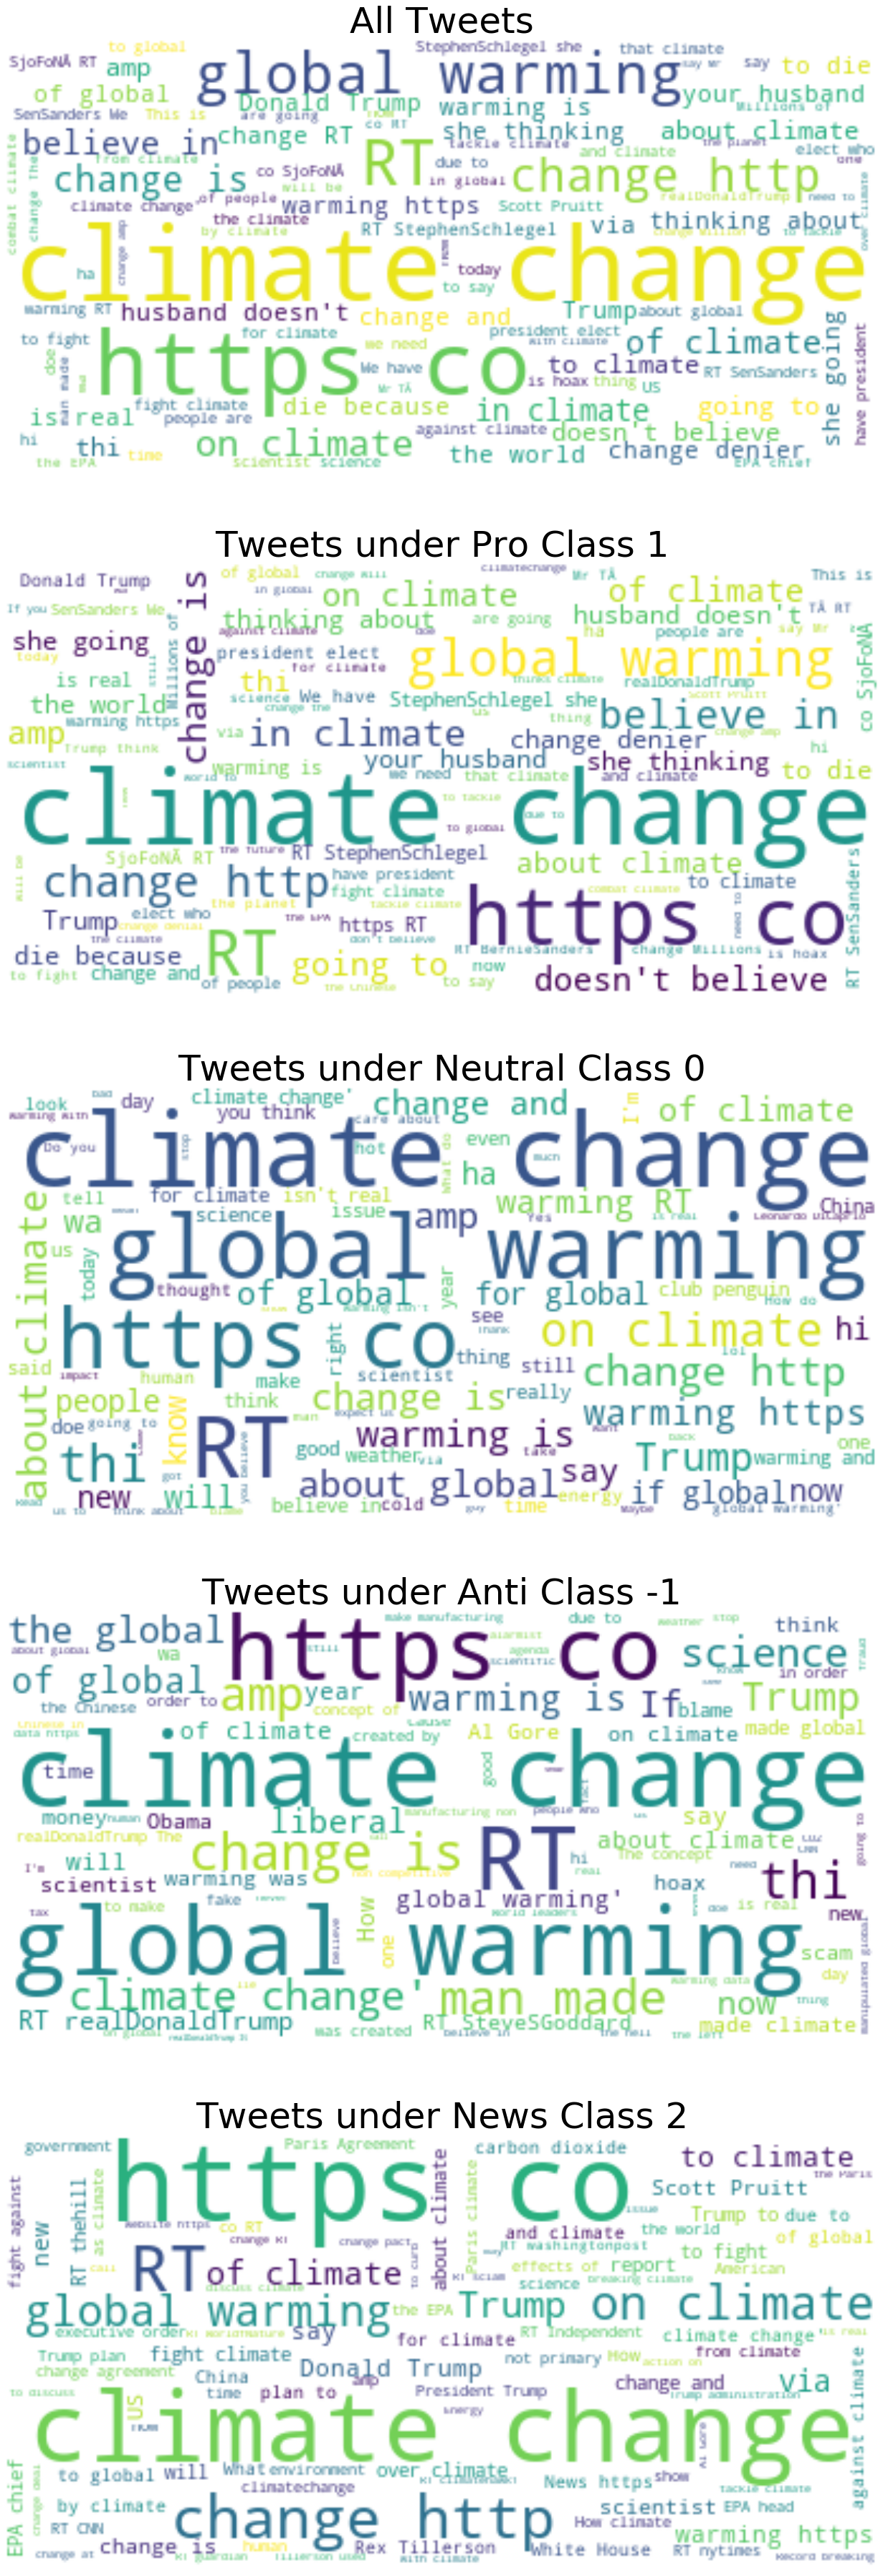

In [26]:
#pd.set_option('display.max_colwidth', 60)
# visualising the messages 
df_senti1 = train_df[train_df['sentiment']==1]
df_senti0 = train_df[train_df['sentiment']==0]
df_senti_neg1 = train_df[train_df['sentiment']==-1]
df_senti2 = train_df[train_df['sentiment']==2]
tweet_All = " ".join(review for review in train_df.message)
tweet_senti1 = " ".join(review for review in df_senti1.message)
tweet_senti0 = " ".join(review for review in df_senti0.message)
tweet_senti_neg1 = " ".join(review for review in df_senti_neg1.message)
tweet_senti2 = " ".join(review for review in df_senti2.message)

fig, ax = plt.subplots(5, 1, figsize  = (65,65))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_1 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_senti1)
wordcloud_0 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_senti0)
wordcloud_neg1 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_senti_neg1)
wordcloud_2 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_senti2)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=50)
ax[0].axis('off')
ax[1].imshow(wordcloud_1, interpolation='bilinear')
ax[1].set_title('Tweets under Pro Class 1',fontsize=50)
ax[1].axis('off')
ax[2].imshow(wordcloud_0, interpolation='bilinear')
ax[2].set_title('Tweets under Neutral Class 0',fontsize=50)
ax[2].axis('off')
ax[3].imshow(wordcloud_neg1, interpolation='bilinear')
ax[3].set_title('Tweets under Anti Class -1',fontsize=50)
ax[3].axis('off')
ax[4].imshow(wordcloud_2, interpolation='bilinear')
ax[4].set_title('Tweets under News Class 2',fontsize=50)
ax[4].axis('off')

In [27]:
def jaccard(str1, str2): 
    '''It takes two strings can be two columns fro a df and returns intersection of twe two  divided by thier union'''
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [28]:
# on the train_df
results_jaccard=[]

for ind,row in train_df.iterrows():
    sentence1 = row.message
    sentence2 = row.clean_message

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [29]:
jaccard = pd.DataFrame(results_jaccard,columns=["message","clean_message","jaccard_score"])
train_df = train_df.merge(jaccard,how='outer')

In [30]:
train_df.head()

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   
2  RT @RawStory: Researchers say we have three ye...   
3  #TodayinMaker# WIRED : 2016 was a pivotal year...   
4  RT @SoyNovioDeTodas: it has / it is 2016, and ...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   
1  it has it is not like we lack evidence of anth...   
2  rt researchers say we have three years to act ...   
3  wired  was a pivotal year in the war on climat...   
4  rt it has it is  and a racist sexist climate c...   

                                         message_POS  \
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   
1  [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...   
2  [(rt, NN), (researchers, NNS), (say, VBP), (we...   
3  [(wired, VBN), (was, VBD), (a, DT), (pivotal, ...   
4  [(rt, NN), (it, PRP), (has, VBZ), (it, PRP), (...   

                                              lemmaa  \
0  polyscimajor epa chief do not think carbon dio...   
1  -PRON- have -PRON- be not like -PRON- lack evi...   
2  rt researcher say -PRON- have three year to ac...   
3  wired   be a pivotal year in the war on climat...   
4  rt -PRON- have -PRON- be   and a racist sexist...   

                                         clean_lemma  \
0  polyscimajor epa chief do not think carbon dio...   
1   have  be not like  lack evidence of anthropog...   
2   researcher say  have three year to act on cli...   
3  wired   be a pivotal year in the war on climat...   
4    have  be   and a racist sexist climate chang...   

                                   tokenized_message  \
0  [polyscimajor, epa, chief, do, not, think, car...   
1  [have, be, not, like, lack, evidence, of, anth...   
2  [researcher, say, have, three, year, to, act, ...   
3  [wired, be, a, pivotal, year, in, the, war, on...   
4  [have, be, and, a, racist, sexist, climate, ch...   

                                     clean_stp_words  Num_words_raw  \
0  [polyscimajor, epa, chief, not, think, carbon,...             19   
1  [not, like, lack, evidence, anthropogenic, glo...             10   
2  [researcher, say, three, year, act, climate, c...             19   
3       [wired, pivotal, year, war, climate, change]             15   
4  [racist, sexist, climate, change, deny, bigot,...             18   

   Num_words_clean  difference_in_wordsNo  jaccard_score  
0               13                      6       0.541667  
1                7                      3       0.692308  
2                8                     11       0.714286  
3                6                      9       0.733333  
4                8                     10       0.478261

kdeplot for Num_words_raw and Num_words_clean

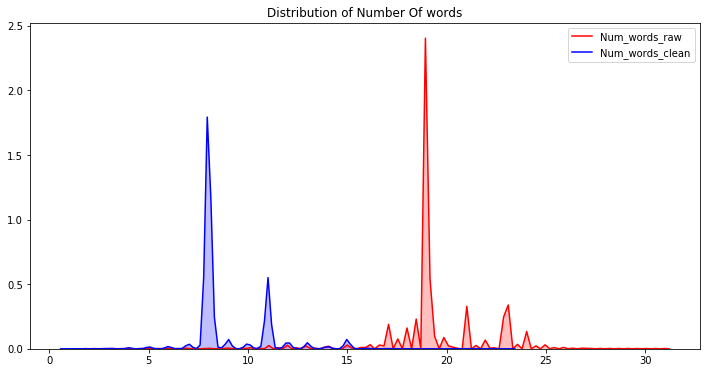

In [46]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train_df['Num_words_raw'], shade=True, color="r").set_title('Distribution of Number Of words')
p2=sns.kdeplot(train_df['Num_words_clean'], shade=True, color="b")

#### Checking the differnce in number of words and jaccard_scores across different Sentiments

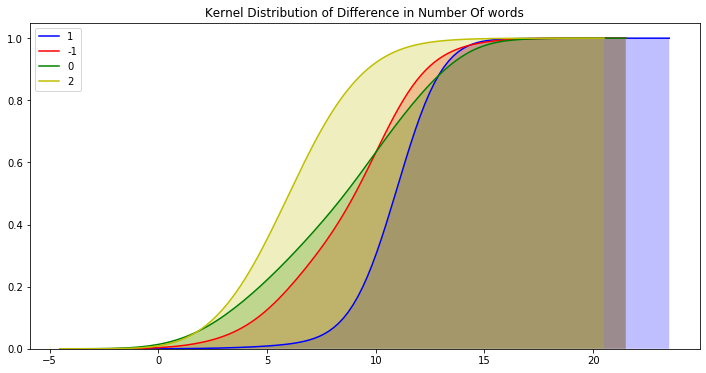

In [32]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train_df[train_df['sentiment']== 1]['difference_in_wordsNo'], shade=True,cumulative=True, bw=1.5, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train_df[train_df['sentiment']== -1]['difference_in_wordsNo'], shade=True,cumulative=True, bw=1.5, color="r")
p3=sns.kdeplot(train_df[train_df['sentiment']== 0]['difference_in_wordsNo'], shade=True, cumulative=True, bw=1.5, color="g")
p4=sns.kdeplot(train_df[train_df['sentiment']== 2]['difference_in_wordsNo'], shade=True, cumulative=True, bw=1.5, color="y")
plt.legend(labels=[1, -1, 0, 2])

### Most Common words in message 

### raw message

In [33]:
train_df['temp_list'] = train_df['message'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [34]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Raw message', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Clean messages

In [35]:
train_df['temp_list0'] = train_df['clean_stp_words']
top = Counter([item for sublist in train_df['temp_list0'] for item in sublist])
temp0 = pd.DataFrame(top.most_common(20))
temp0.columns = ['Common_words','count']
temp0.style.background_gradient(cmap='Greens')

In [36]:
fig = px.bar(temp0, x="count", y="Common_words", title='Commmon Words in cleaned message', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

with stop words removed, now the most common word is climate 

## Most common words sentiment wise in raw message

In [37]:
Pro = train_df[train_df['sentiment']==1]
Anti = train_df[train_df['sentiment']== -1]
Neutral = train_df[train_df['sentiment']==0]
News = train_df[train_df['sentiment']== 2]

In [38]:
#MosT common positive words(Pro)
top = Counter([item for sublist in Pro['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

In [39]:
#MosT common negative words(Anti)
top = Counter([item for sublist in Anti['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [40]:
#MosT common words in Neutral sentiment
top = Counter([item for sublist in Neutral['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

In [41]:
#MosT common words in News sentiment
top = Counter([item for sublist in News['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

Clean messages sentiment wise 

Visuals for nomber of clean message and raw with thier diffences and jaccard score.

### Below is modeling of the data

SUPPORT VECTOR MACHINES AND MODEL TUNING

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics

In [25]:
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok

def detokenization(text):
    '''counter slpit the message into taken of words'''
    detokenizer = Detok()
    text = detokenizer.detokenize(text)
    return text
train_df['detokenized'] = train_df['clean_stp_words'].apply(lambda x: detokenization(x))
test_df['detokenized'] = test_df['clean_stp_words'].apply(lambda x: detokenization(x))

In [26]:
train_df

sentiment                                            message  tweetid  \
0              1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1              1  It's not like we lack evidence of anthropogeni...   126103   
2              2  RT @RawStory: Researchers say we have three ye...   698562   
3              1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4              1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   
...          ...                                                ...      ...   
15814          1  RT @ezlusztig: They took down the material on ...    22001   
15815          2  RT @washingtonpost: How climate change could b...    17856   
15816          0  notiven: RT: nytimesworld :What does Trump act...   384248   
15817         -1  RT @sara8smiles: Hey liberals the climate chan...   819732   
15818          0  RT @Chet_Cannon: .@kurteichenwald's 'climate c...   806319   

                                       fixed_cntractions  \
0      PolySciMajor EPA chief does not think carbon d...   
1      it has / it is not like we lack evidence of an...   
2      RT @RawStory: Researchers say we have three ye...   
3      #TodayinMaker# WIRED : 2016 was a pivotal year...   
4      RT @SoyNovioDeTodas: it has / it is 2016, and ...   
...                                                  ...   
15814  RT @ezlusztig: They took down the material on ...   
15815  RT @washingtonpost: How climate change could b...   
15816  notiven: RT: nytimesworld :What does Trump act...   
15817  RT @sara8smiles: Hey liberals the climate chan...   
15818  RT @Chet_Cannon: .@kurteichenwald's 'climate c...   

                                           clean_message  \
0      polyscimajor epa chief does not think carbon d...   
1      it has it is not like we lack evidence of anth...   
2      rt researchers say we have three years to act ...   
3      wired  was a pivotal year in the war on climat...   
4      rt it has it is  and a racist sexist climate c...   
...                                                  ...   
15814  rt they took down the material on global warmi...   
15815  rt how climate change could be breaking up a  ...   
15816  notiven rt nytimesworld what does trump actual...   
15817  rt hey liberals the climate change crap is a h...   
15818  rt cannon s climate change equation in  screen...   

                                             message_POS  \
0      [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   
1      [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...   
2      [(rt, NN), (researchers, NNS), (say, VBP), (we...   
3      [(wired, VBN), (was, VBD), (a, DT), (pivotal, ...   
4      [(rt, NN), (it, PRP), (has, VBZ), (it, PRP), (...   
...                                                  ...   
15814  [(rt, NN), (they, PRP), (took, VBD), (down, RP...   
15815  [(rt, VB), (how, WRB), (climate, JJ), (change,...   
15816  [(notiven, RB), (rt, VB), (nytimesworld, RP), ...   
15817  [(rt, NN), (hey, NN), (liberals, VBZ), (the, D...   
15818  [(rt, NN), (cannon, NN), (s, JJ), (climate, NN...   

                                                  lemmaa  \
0      polyscimajor epa chief do not think carbon dio...   
1      -PRON- have -PRON- be not like -PRON- lack evi...   
2      rt researcher say -PRON- have three year to ac...   
3      wired   be a pivotal year in the war on climat...   
4      rt -PRON- have -PRON- be   and a racist sexist...   
...                                                  ...   
15814  rt -PRON- take down the material on global war...   
15815  rt how climate change could be break up a   mi...   
15816  notiven rt nytimesworld what do trump actually...   
15817  rt hey liberal the climate change crap be a ho...   
15818  rt cannon s climate change equation in   scree...   

                                             clean_lemma  \
0      polyscimajor epa chief do not think carbon dio...   
1       have  be not like  lack evidence o

### Building pipelines to vectorize the data, then train and fit a model

In [27]:
# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

### Training on raw data

In [51]:
# defing the x and y varible
X= train_df['clean_message']
y=train_df['sentiment']
# slpitting the X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])
text_clf_lsvc.fit(X_train, y_train)
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))
# Print a classification report
print(metrics.classification_report(y_test,predictions))

[[  289    32   101    12]
 [   16   410   223    44]
 [   29    83 27855   145]
 [    5    20   163   632]]
              precision    recall  f1-score   support

          -1       0.85      0.67      0.75       434
           0       0.75      0.59      0.66       693
           1       0.98      0.99      0.99     28112
           2       0.76      0.77      0.76       820

    accuracy                           0.97     30059
   macro avg       0.84      0.75      0.79     30059
weighted avg       0.97      0.97      0.97     30059



In [133]:
# on the test set
X_test = test_df['message']
# Form a prediction set
raw_pred = text_clf_lsvc.predict(X_test)
# Donverting the predictions to dataframe
raw_pred = pd.DataFrame(data=raw_pred,
                                 columns=['sentiment'],
                                 index=test_df['tweetid'])
raw_pred.reset_index(inplace=True)
raw_pred.to_csv(r"C:\Users\elton\Documents\Jm_team\Classification_Predict_Package\predictions_SVC\SCV_raw_pred.csv", index=False)

### Training on column clean_message

In [134]:
# defing the x and y varible
X= train_df['clean_message']
y=train_df['sentiment']
# slpitting the X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])
text_clf_lsvc.fit(X_train, y_train)
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))
# Print a classification report
print(metrics.classification_report(y_test,predictions))

[[  289    32   101    12]
 [   16   410   223    44]
 [   29    83 27855   145]
 [    5    20   163   632]]
              precision    recall  f1-score   support

          -1       0.85      0.67      0.75       434
           0       0.75      0.59      0.66       693
           1       0.98      0.99      0.99     28112
           2       0.76      0.77      0.76       820

    accuracy                           0.97     30059
   macro avg       0.84      0.75      0.79     30059
weighted avg       0.97      0.97      0.97     30059



In [135]:
# on the test set
X_test = test_df['clean_message']
# Form a prediction set
cln_pred = text_clf_lsvc.predict(X_test)
# Donverting the predictions to dataframe
cln_pred = pd.DataFrame(data=cln_pred,
                                 columns=['sentiment'],
                                 index=test_df['tweetid'])
cln_pred.reset_index(inplace=True)
cln_pred.to_csv(r"C:\Users\elton\Documents\Jm_team\Classification_Predict_Package\predictions_SVC\SCV_clean_msg_pred.csv", index=False)

### Training on final cleaned detokenized message

In [136]:
# defing the x and y varible
X= train_df['detokenized']
y=train_df['sentiment']
# slpitting the X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Feeding the training data through the Linear SVC pipeline
text_clf_lsvc.fit(X_train, y_train)
# Form a prediction set
dtknz_pred = text_clf_lsvc.predict(X_test)
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,dtknz_pred))
# Print a classification report
print(metrics.classification_report(y_test,dtknz_pred))

[[  292    26    94    22]
 [   22   395   233    43]
 [   31    85 27839   157]
 [    3    23   174   620]]
              precision    recall  f1-score   support

          -1       0.84      0.67      0.75       434
           0       0.75      0.57      0.65       693
           1       0.98      0.99      0.99     28112
           2       0.74      0.76      0.75       820

    accuracy                           0.97     30059
   macro avg       0.83      0.75      0.78     30059
weighted avg       0.97      0.97      0.97     30059



In [142]:
# on the test set
X_test = test_df['detokenized']
# Form a prediction set
dtkz_pred = text_clf_lsvc.predict(X_test)
# Converting the predictions to dataframe
dtkz_pred = pd.DataFrame(data=dtkz_pred,
                                 columns=['sentiment'],
                                 index=test_df['tweetid'])
dtkz_pred.reset_index(inplace=True)
dtkz_pred.to_csv(r"C:\Users\elton\Documents\Jm_team\Classification_Predict_Package\predictions_SVC\SVC_dtkz_pred.csv", index=False)

### training the model withou retweets

In [52]:
train_df.shape

(150291, 17)

In [53]:
new_df = train_df.drop_duplicates(subset=['detokenized'], keep='first')

In [58]:
new_df.shape

(13157, 17)

In [55]:
# defing the x and y varible
X= new_df['detokenized']
y=new_df['sentiment']
# slpitting the X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Feeding the training data through the Linear SVC pipeline
text_clf_lsvc.fit(X_train, y_train)
# Form a prediction set
dtknz_pred = text_clf_lsvc.predict(X_test)
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,dtknz_pred))
# Print a classification report
print(metrics.classification_report(y_test,dtknz_pred))

[[  93   31  105   18]
 [  21  137  218   39]
 [  32   98 1105  154]
 [   7   27  170  377]]
              precision    recall  f1-score   support

          -1       0.61      0.38      0.46       247
           0       0.47      0.33      0.39       415
           1       0.69      0.80      0.74      1389
           2       0.64      0.65      0.64       581

    accuracy                           0.65      2632
   macro avg       0.60      0.54      0.56      2632
weighted avg       0.64      0.65      0.64      2632



In [56]:
# on the test set
X_test = test_df['detokenized']
# Form a prediction set
dtkz_pred = text_clf_lsvc.predict(X_test)
# Converting the predictions to dataframe
dtkz_pred = pd.DataFrame(data=dtkz_pred,
                                 columns=['sentiment'],
                                 index=test_df['tweetid'])
dtkz_pred.reset_index(inplace=True)
dtkz_pred.to_csv(r"C:\Users\elton\Documents\Jm_team\Classification_Predict_Package\predictions_SVC\SVC_noretweet_pred.csv", index=False)

In [72]:
temp = new_df.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)
temp['percentage'] = (temp['message']/temp['message'].sum())*100
temp.style.background_gradient(cmap='Purples')

As you can see, our four classes are imbalanced. To put this in perspective as to why this is such an issue, say we had a model that always predicts that a given message is class 1 (clearly a really bad model!). 

Resampling techniques to fix this. Notice that we are keeping our features and labels together for the time being so that they get sampled together (otherwise we risk mixing labels and observations):

In [61]:
train_df.shape

(150291, 17)

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   
1  it has / it is not like we lack evidence of an...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   
1  it has it is not like we lack evidence of anth...   

                                         message_POS  \
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   
1  [(it, PRP), (has, VBZ), (it, PRP), (is, VBZ), ...   

                                              lemmaa  \
0  polyscimajor epa chief do not think carbon dio...   
1  -PRON- have -PRON- be not like -PRON- lack evi...   

                                         clean_lemma  \
0  polyscimajor epa chief do not think carbon dio...   
1   have  be not like  lack evidence of anthropog...   

                                   tokenized_message  \
0  [polyscimajor, epa, chief, do, not, think, car...   
1  [have, be, not, like, lack, evidence, of, anth...   

                                     clean_stp_words  Num_words_raw  \
0  [polyscimajor, epa, chief, not, think, carbon,...             19   
1  [not, like, lack, evidence, anthropogenic, glo...             10   

   Num_words_clean  difference_in_wordsNo  jaccard_score  \
0               13                      6       0.541667   
1                7                      3       0.692308   

                                           temp_list  \
0  [PolySciMajor, EPA, chief, doesn't, think, car...   
1  [It's, not, like, we, lack, evidence, of, anth...   

                                          temp_list0  \
0  [polyscimajor, epa, chief, not, think, carbon,...   
1  [not, like, lack, evidence, anthropogenic, glo...   

                                         detokenized  
0  polyscimajor epa chief not think carbon dioxid...  
1  not like lack evidence anthropogenic global wa...

In [38]:
from sklearn.utils import resample

### Downsampling the majority class

Since the  class Pro(1),News (2) and Neutral(0) has so many observations, we can reduce it's size by taking a small random subset of observations to match the size of the  class Anti(-1). Because this approach reduces the overall size of the dataset.

In [92]:
Pro = train_df[train_df['sentiment']==1]
Anti = train_df[train_df['sentiment']== -1]
Neutral = train_df[train_df['sentiment']==0]
News = train_df[train_df['sentiment']== 2]

In [93]:
# Downsample majority
Pro_downsampled = resample(Pro,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(Anti), # match number in minority class
                          random_state=27) # reproducible results
Neutral_downsampled = resample(Neutral,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(Anti), # match number in minority class
                          random_state=27) # reproducible results
News_downsampled = resample(News,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(Anti), # match number in minority class
                          random_state=27) # reproducible results



# Combine downsampled majority class with minority class
downsampled2 = pd.concat([Pro_downsampled,Neutral_downsampled,News_downsampled,Anti])

# Check new class counts
#downsampled['Anti'].value_counts()

In [80]:
temp = new_df.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)
temp['percentage'] = (temp['message']/temp['message'].sum())*100
temp.style.background_gradient(cmap='Purples')

In [86]:
downsampled.shape

(4712, 17)

In [87]:
temp = downsampled.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)
temp['percentage'] = (temp['message']/temp['message'].sum())*100
temp.style.background_gradient(cmap='Purples')

In [94]:
temp = downsampled2.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)
temp['percentage'] = (temp['message']/temp['message'].sum())*100
temp.style.background_gradient(cmap='Purples')

In [88]:
downsampled.head()

sentiment                                            message  tweetid  \
147037          1  No doubt part of the reason the @NationalFarme...   457901   
144186          1  @decathlonsport, I'lltake Rahul Gandhi so he c...   772814   
134863          1  And people say global warming doesn't exist. S...   523887   
146338          1  RT @coal_ind_today: Why the media must make cl...   812462   
142737          1  RT @NRDC: Unacceptable. The Trump administrati...   932323   

                                        fixed_cntractions  \
147037  No doubt part of the reason the @NationalFarme...   
144186  @decathlonsport, I'lltake Rahul Gandhi so he c...   
134863  And people say global warming does not exist. ...   
146338  RT @coal_ind_today: Why the media must make cl...   
142737  RT @NRDC: Unacceptable. The Trump administrati...   

                                            clean_message  \
147037  no doubt part of the reason the are calling fo...   
144186  i lltake rahul gandhi so he can see global war...   
134863  and people say global warming does not exist s...   
146338  rt ind today why the media must make climate c...   
142737  rt unacceptable the trump administration is ex...   

                                              message_POS  \
147037  [(no, DT), (doubt, NN), (part, NN), (of, IN), ...   
144186  [(i, NNS), (lltake, VBP), (rahul, JJ), (gandhi...   
134863  [(and, CC), (people, NNS), (say, VBP), (global...   
146338  [(rt, NN), (ind, NN), (today, NN), (why, WRB),...   
142737  [(rt, NN), (unacceptable, JJ), (the, DT), (tru...   

                                                   lemmaa  \
147037  no doubt part of the reason the be call for re...   
144186  i lltake rahul gandhi so -PRON- can see global...   
134863  and people say global warming do not exist so ...   
146338  rt ind today why the medium must make climate ...   
142737  rt unacceptable the trump administration be ex...   

                                              clean_lemma  \
147037  no doubt pa of the reason the be call for real...   
144186  i lltake rahul gandhi so  can see global warmi...   
134863  and people say global warming do not exist so ...   
146338   ind today why the medium must make climate ch...   
142737   unacceptable the trump administration be expe...   

                                        tokenized_message  \
147037  [no, doubt, pa, of, the, reason, the, be, call...   
144186  [i, lltake, rahul, gandhi, so, can, see, globa...   
134863  [and, people, say, global, warming, do, not, e...   
146338  [ind, today, why, the, medium, must, make, cli...   
142737  [unacceptable, the, trump, administration, be,...   

                                          clean_stp_words  Num_words_raw  \
147037  [doubt, pa, reason, call, real, action, climat...             18   
144186  [lltake, rahul, gandhi, see, global, warming, ...             22   
134863  [people, say, global, warming, not, exist, sum...             20   
146338  [ind, today, medium, must, make, climate, chan...             16   
142737  [unacceptable, trump, administration, expect, ...             19   

        Num_words_clean  difference_in_wordsNo  jaccard_score  \
147037                8                     10       0.823529   
144186               12                     10       0.809524   
134863               11                      9       0.464286   
146338               11                      5       0.777778   
142737               11                      8       0.666667   

                                                temp_list  \
147037  [No, doubt, part, of, the, reason, the, @Natio...   
144186  [@decathlonsport,, I'lltake, Rahul, Gandhi, so...   
134863  [And, people, say, global, warming, doesn't, e...   
146338  [RT, @coal_ind_today:, Why, the, media, must, ...   
142737  [RT, @NRDC:, Unacceptable., The, Trump, admini...   

                                               temp_list0  \
147037  [doubt, pa, reason, call, real, act

In [90]:
# defing the x and y varible
X= downsampled['detokenized']
y=downsampled['sentiment']
# slpitting the X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Feeding the training data through the Linear SVC pipeline
text_clf_lsvc.fit(X_train, y_train)
# Form a prediction set
dtknz_pred = text_clf_lsvc.predict(X_test)
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,dtknz_pred))
# Print a classification report
print(metrics.classification_report(y_test,dtknz_pred))

[[140  36  37  16]
 [ 51 117  39  25]
 [ 33  38 123  56]
 [ 13  21  38 160]]
              precision    recall  f1-score   support

          -1       0.59      0.61      0.60       229
           0       0.55      0.50      0.53       232
           1       0.52      0.49      0.51       250
           2       0.62      0.69      0.65       232

    accuracy                           0.57       943
   macro avg       0.57      0.57      0.57       943
weighted avg       0.57      0.57      0.57       943



In [91]:
# on the test set
X_test = test_df['detokenized']
# Form a prediction set
dtkz_pred = text_clf_lsvc.predict(X_test)
# Converting the predictions to dataframe
dtkz_pred = pd.DataFrame(data=dtkz_pred,
                                 columns=['sentiment'],
                                 index=test_df['tweetid'])
dtkz_pred.reset_index(inplace=True)
dtkz_pred.to_csv(r"C:\Users\elton\Documents\Jm_team\Classification_Predict_Package\predictions_SVC\SVC_balanced_pred.csv", index=False)

In [95]:
# defing the x and y varible
X= downsampled2['detokenized']
y=downsampled2['sentiment']
# slpitting the X and y into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Feeding the training data through the Linear SVC pipeline
text_clf_lsvc.fit(X_train, y_train)
# Form a prediction set
dtknz_pred = text_clf_lsvc.predict(X_test)
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,dtknz_pred))
# Print a classification report
print(metrics.classification_report(y_test,dtknz_pred))

[[354  60   0  24]
 [ 49 315   4  44]
 [  6  11 431  12]
 [ 24  42   2 397]]
              precision    recall  f1-score   support

          -1       0.82      0.81      0.81       438
           0       0.74      0.76      0.75       412
           1       0.99      0.94      0.96       460
           2       0.83      0.85      0.84       465

    accuracy                           0.84      1775
   macro avg       0.84      0.84      0.84      1775
weighted avg       0.85      0.84      0.84      1775



In [96]:
# on the test set
X_test = test_df['detokenized']
# Form a prediction set
dtkz_pred = text_clf_lsvc.predict(X_test)
# Converting the predictions to dataframe
dtkz_pred = pd.DataFrame(data=dtkz_pred,
                                 columns=['sentiment'],
                                 index=test_df['tweetid'])
dtkz_pred.reset_index(inplace=True)
dtkz_pred.to_csv(r"C:\Users\elton\Documents\Jm_team\Classification_Predict_Package\predictions_SVC\SVC_balanced_pred2.csv", index=False)

# down sizing on average

In [28]:
Pro = train_df[train_df['sentiment']==1]
Anti = train_df[train_df['sentiment']== -1]
Neutral = train_df[train_df['sentiment']==0]
News = train_df[train_df['sentiment']== 2]

In [29]:
temp = train_df.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)

In [32]:
temp

sentiment  message
2          1     8530
3          2     3640
1          0     2353
0         -1     1296

In [35]:
avg = round(temp['message'].sum()/4,0)

In [36]:
avg

3955.0

In [39]:
# balancing
Pro_downsampled = resample(Pro,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=avg, # match number in minority class
                          random_state=27) # reproducible results
Neutral_downsampled = resample(Neutral,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=avg, # match number in minority class
                          random_state=27) # reproducible results
News_downsampled = resample(News,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=avg, # match number in minority class
                          random_state=27) # reproducible results

Anti_downsampled = resample(Anti,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=avg, # match number in minority class
                          random_state=27) # reproducible results


# Combine downsampled majority class with minority class
downsampled3 = pd.concat([Pro_downsampled,Neutral_downsampled,Anti_downsampled, News_downsampled,Anti])

# Check new class counts
#downsampled['Anti'].value_counts()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

### Synthetic Minority Oversampling Technique

In [41]:
#sudo pip install imbalanced-learn

In [43]:
train_df.head(1)

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   

                                   fixed_cntractions  \
0  PolySciMajor EPA chief does not think carbon d...   

                                       clean_message  \
0  polyscimajor epa chief does not think carbon d...   

                                         message_POS  \
0  [(polyscimajor, JJ), (epa, NN), (chief, NN), (...   

                                              lemmaa  \
0  polyscimajor epa chief do not think carbon dio...   

                                         clean_lemma  \
0  polyscimajor epa chief do not think carbon dio...   

                                   tokenized_message  \
0  [polyscimajor, epa, chief, do, not, think, car...   

                                     clean_stp_words  \
0  [polyscimajor, epa, chief, not, think, carbon,...   

                                         detokenized  
0  polyscimajor epa chief not think carbon dioxid...

In [51]:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer())])
X = train_df['detokenized']
y = train_df['sentiment']
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer())])

In [56]:
TfidfVectorizer(X_train)

TfidfVectorizer(input=584      epa head scott pruitt deny carbon dioxide caus...
9155     top download federal site right park service r...
9623                         zimmer iceberg global warming
6820     mill everybody know climate change still real ...
4549           sadly climate change big hoax enjoy ur life
                               ...                        
13123    pittsburgh confront variety extreme weather st...
3264                moon global warming freakin joke right
9845     science amp research not disappear not dangero...
10799      nicolas cage star climate change disaster movie
2732     not think even hill mile hope global warming t...
Name: detokenized, Length: 11073, dtype: object)

In [46]:
from imblearn.over_sampling import SMOTE

In [50]:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer())])
X = train_df['detokenized']
y = train_df['sentiment']
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
text_clf_lsvc.fit(X_train, y_train)
columns = X_train
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))


AttributeError: 'Series' object has no attribute 'columns'